# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file. 


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent 
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.** 
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state. 
* **Discrete** means that we have a **finite set of states.** The maze has a finite set 
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The 
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [2]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

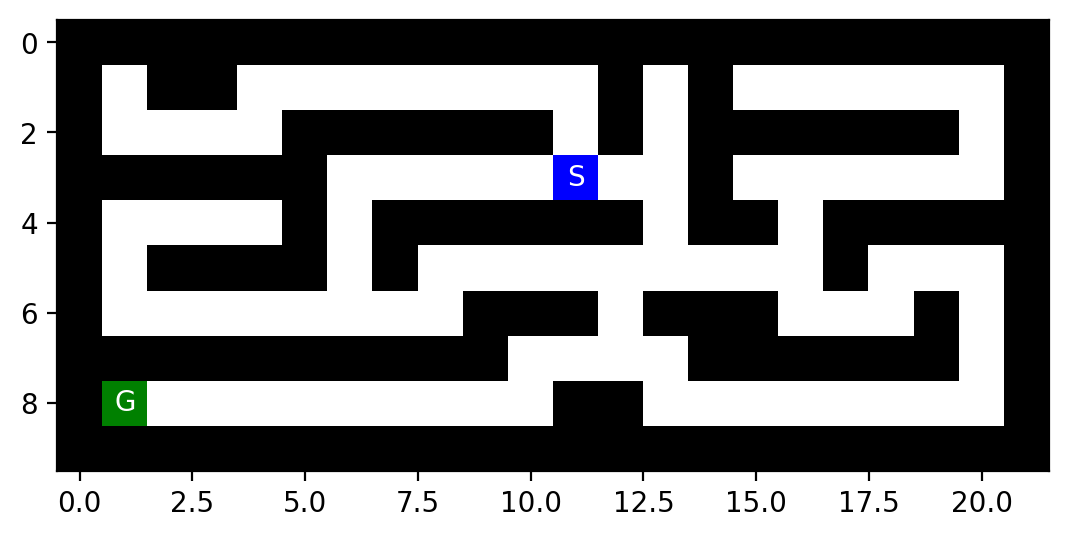

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

In [7]:
# Your answer goes here
# initial state : la trang thai khoi dau cua bai toan
# VD: ô bắt đầu
# Aciton : hanh dong cua agent khi qua buoc tiep nhan thong tin
# VD: Hành động di chuyển trái , phải , lên , xuống
# Transition model : là 1 hàm gồm tham số đầu vào là state và action ,trả về trạng thái từ kết quả của việc thực hiện hành động a từ trạng thái s
# # Goal state: Trang thai cuoi cung sau khi thuc hien nhieu hanh dong
# VD : ô cần đến
# Path cost: Là chi phi phí thực hiện sau khi trải qua 1 chuỗi hành động
# VD : số ô di chuyển.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [8]:
# Your answer goes here
# n: kich thuoc khong gian tat ca trang thai 
# VD : kich thuoc cua bai toan maze: cot x dong
# d: do sau cua cay da duoc toi uu dai dien cho duong di tu trang thai dau den trang thai dich
# VD : so o di chuyen toi uu tu trang thai dau den trang thai dich
# m: do sau toi da cua cay , duong di tu trang thai ban dau den trang thai dich chua duoc toi uu
# VD : khoang cach toi da cua bai toan maze : khoang cach mahattan tu o bat dau den dich
# b: số node con tối đa của 1 nhánh
# VD : kich thuoc la 4 ( trai , phai , len , xuong)

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking. 
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

Path form start to goal using BFS:


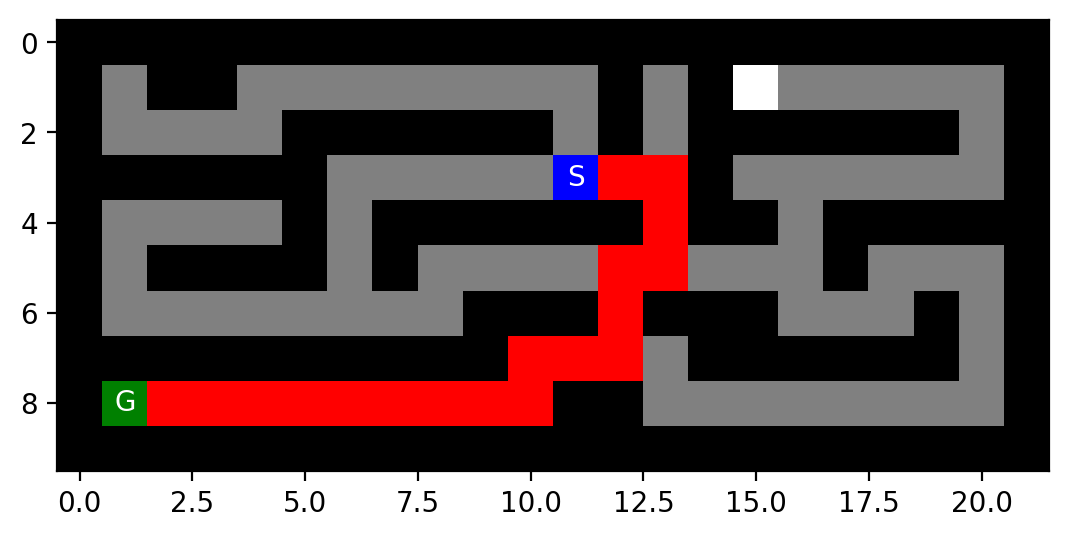

Path form start to goal using DFS:


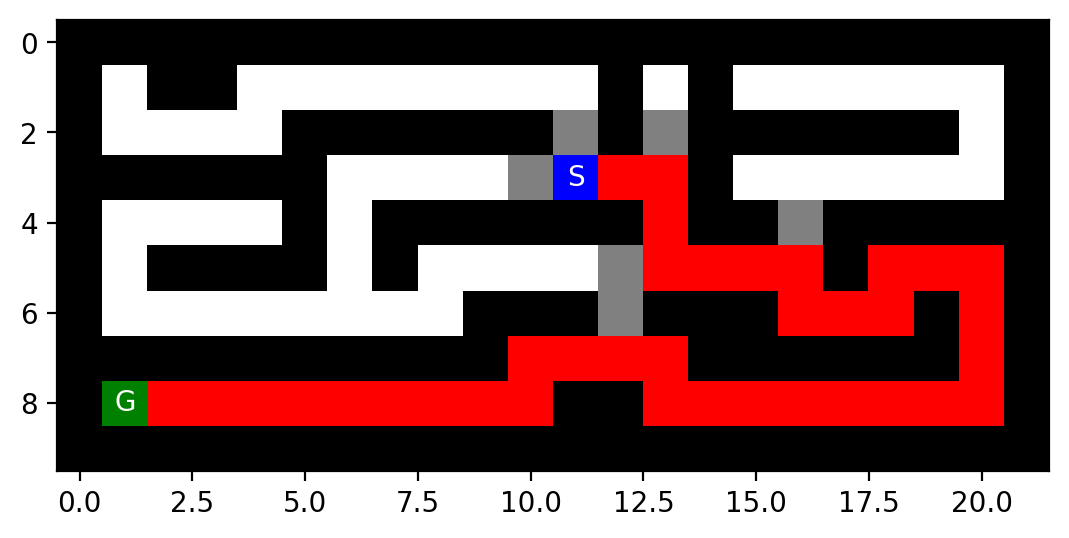

In [24]:
# Your code goes here
import maze_helper as mh
import matplotlib.pyplot as plt
import  numpy as np
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
    def __str__(self):
        return f"pos = ({self.pos[0]} ,{self.pos[1]}); parent = {self.parent}"
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
        while not node.parent is None:
            node = node.parent
            path.append(node)
        path.reverse()
        return(path)
def BFS(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop(0)
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze




# solution = BFS(maze)
# print(f"Path form start to goal using BFS:")
# print_solution(solution)
# print(f"Cost from start to goal: {len(solution)}")


def DFS(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop()
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
print(f"Path form start to goal using BFS:")
solution = BFS(maze)
mh.show_maze(solution)
print(f"Path form start to goal using DFS:")
solution = DFS(maze)
mh.show_maze(solution)


How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [10]:
# Discussion
# nếu không sử dụng reached set thì sẽ bị lặp vô hạn khi gặp vòng lặp trong mê cung

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [11]:
# BFS:

# Complete: Có, vì BFS sẽ luôn tìm ra lời giải nếu tồn tại đường đi từ start đến goal.
# Optimal: Có, vì BFS luôn tìm được đường đi ngắn nhất (ít bước nhất) trong môi trường với chi phí đồng nhất.
# DFS:

# Complete: Không đảm bảo, vì DFS có thể đi vào vòng lặp vô hạn nếu không kiểm tra chu trình, hoặc bỏ lỡ lời giải nếu không duyệt hết các nhánh.
# Optimal: Không, vì DFS có thể tìm ra lời giải không phải ngắn nhất.
# Time and Space Complexity:

# BFS:

# Time complexity: O(b^d), với b là branching factor (số nhánh tối đa), d là độ sâu lời giải tối ưu.
# Space complexity: O(b^d), vì BFS lưu trữ tất cả các node ở mỗi mức trước khi chuyển sang mức tiếp theo (frontier có thể rất lớn).
# DFS:

# Time complexity: O(b^m), với m là độ sâu tối đa của cây tìm kiếm.
# Space complexity: O(bm), vì DFS chỉ lưu trữ các node trên đường đi hiện tại (stack), nên sử dụng ít bộ nhớ hơn nhiều so với BFS.
# So sánh không gian giữa BFS và DFS:

# BFS cần lưu trữ toàn bộ frontier ở mỗi mức, nên tốn rất nhiều bộ nhớ khi d lớn.
# DFS chỉ cần lưu đường đi hiện tại (stack), nên bộ nhớ tăng tuyến tính theo độ sâu, phù hợp với các bài toán có không gian trạng thái lớn.


# So sánh không gian giữa BFS và DFS:

# BFS cần lưu trữ toàn bộ frontier ở mỗi mức, nên tốn rất nhiều bộ nhớ khi d lớn.
# DFS chỉ cần lưu đường đi hiện tại (stack), nên bộ nhớ tăng tuyến tính theo độ sâu, phù hợp với các bài toán có không gian trạng thái lớn.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

Path form start to goal using Greedy Best-First Search:


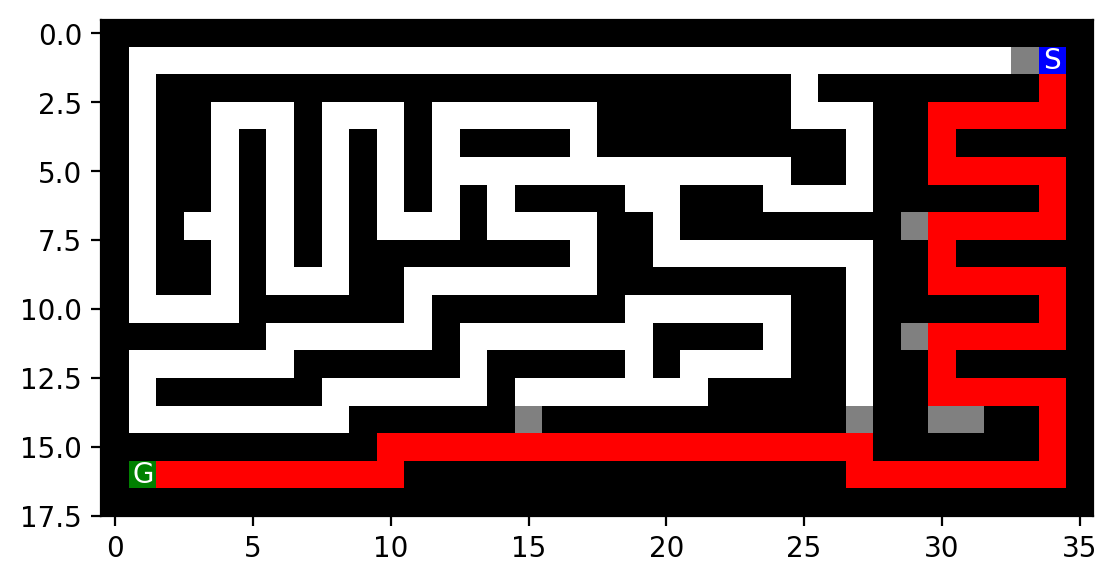

Path form start to goal using A* Search:


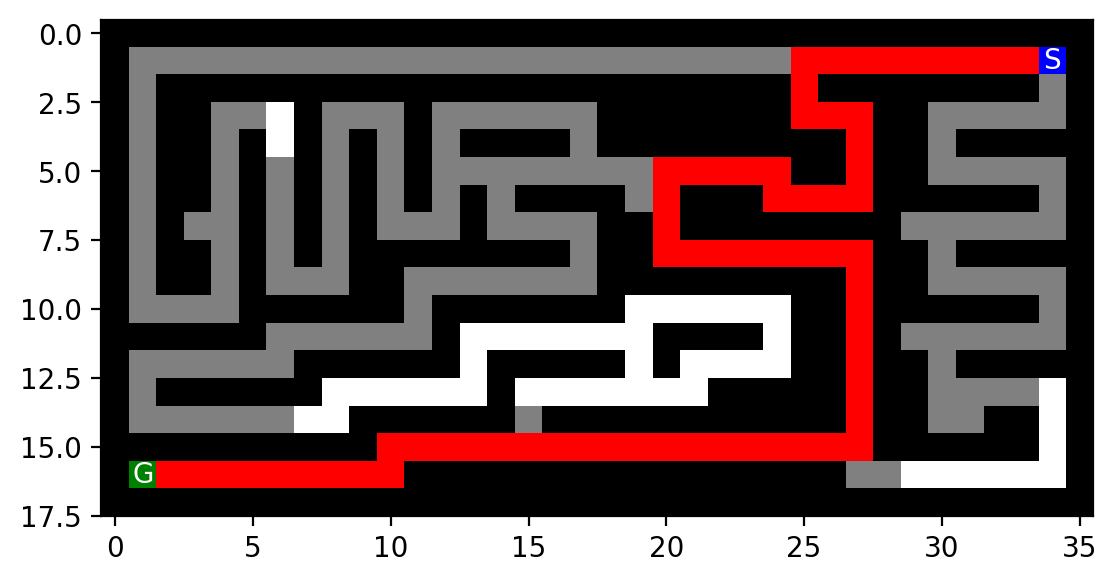

In [26]:
# Your code goes here
def Greedy_best_first_search(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None,action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        # Sort the frontier based on the heuristic (Manhattan distance)
        frontier.sort(key=lambda node: abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)  # Pop the node with the lowest heuristic value
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze

def A_star_search(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None,action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        # Sort the frontier based on the f(n) = g(n) + h(n)
        frontier.sort(key=lambda node: node.cost + abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)  # Pop the node with the lowest f(n) value
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze

with open("medium_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
print(f"Path form start to goal using Greedy Best-First Search:")
solution = Greedy_best_first_search(maze)
mh.show_maze(solution)
print(f"Path form start to goal using A* Search:")
solution = A_star_search(maze)
mh.show_maze(solution)

Are your implementations complete and optimal? What is the time and space complexity?

In [13]:
# Discussion
# độ phức tạp về thời gian của Greedy Best-First Search là O(b^m) trong trường hợp xấu nhất, trong đó b là số nhánh tối đa và m là độ sâu tối đa của cây tìm kiếm. Tuy nhiên, trong thực tế, Greedy Best-First Search thường nhanh hơn so với các thuật toán tìm kiếm khác vì nó tập trung vào việc khám phá các nút có giá trị heuristic thấp nhất trước.
# độ phức tạp về không gian của Greedy Best-First Search là O(b^m) trong trường hợp xấu nhất, vì nó cần lưu trữ tất cả các nút trong frontier. Tuy nhiên, trong thực tế, không gian sử dụng thường nhỏ hơn so với các thuật toán tìm kiếm khác vì nó không cần lưu trữ tất cả các nút đã thăm.

# Độ phức tạp về thời gian của A* Search là O(b^d) trong trường hợp xấu nhất, trong đó b là số nhánh tối đa và d là độ sâu của cây tìm kiếm. Tuy nhiên, nếu hàm heuristic được chọn tốt (như Manhattan distance trong trường hợp này), A* Search có thể hoạt động rất hiệu quả và gần như tuyến tính với độ sâu của giải pháp.
# Độ phức tạp về không gian của A* Search cũng là O(b^d) trong trường hợp xấu nhất, vì nó cần lưu trữ tất cả các nút trong frontier và các nút đã thăm. Tuy nhiên, tương tự như thời gian, nếu hàm heuristic được chọn tốt, không gian sử dụng có thể giảm đáng kể.


## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [14]:
#BFS

def BFS_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)  
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop(0)
        node_expanded += 1  
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size

#DFS

def DFS_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop()
        node_expanded += 1  
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size

def Greedy_best_first_search_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        frontier.sort(key=lambda node: abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)
        node_expanded += 1  
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size

def A_star_search_custom(maze):
    path_cost = 0
    node_expanded = 0
    max_frontier_size = 0
    max_depth = 0
    max_of_node_in_memory = 0
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = mh.find_pos(maze, what="G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, None, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        frontier.sort(key=lambda node: node.cost + abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1]))
        node = frontier.pop(0)
        node_expanded += 1  
        if node.pos == end:
            path = node.get_path_from_root()
            path_cost = len(path) - 1
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze, path_cost, node_expanded, max_depth, max_of_node_in_memory, max_frontier_size
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
                max_depth = max(max_depth, new_node.cost)
        max_frontier_size = max(max_frontier_size, len(frontier))
        max_of_node_in_memory = max(max_of_node_in_memory, len(frontier) + len(reached))
    return new_maze, path_cost, node_expanded, max_depth,  max_of_node_in_memory, max_frontier_size


In [15]:
# Add code

maze_str = ["small_maze.txt", "medium_maze.txt", "large_maze.txt","loops_maze.txt","L_maze.txt","empty_maze.txt","empty_maze_2.txt","open_maze.txt"]







Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

Results for maze in file: small_maze.txt


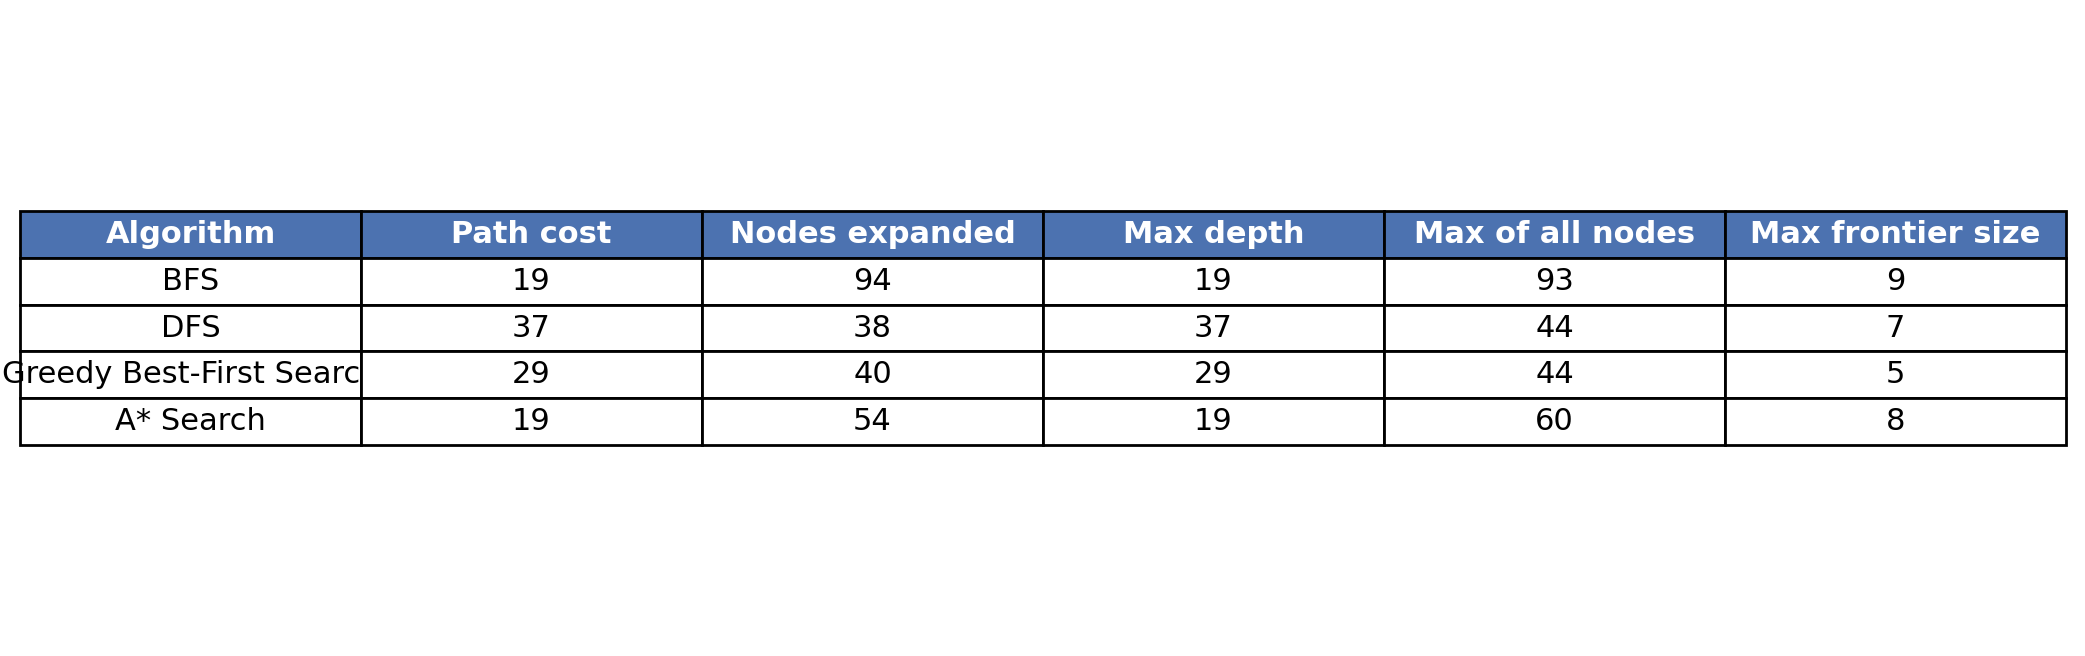

Results for maze in file: medium_maze.txt


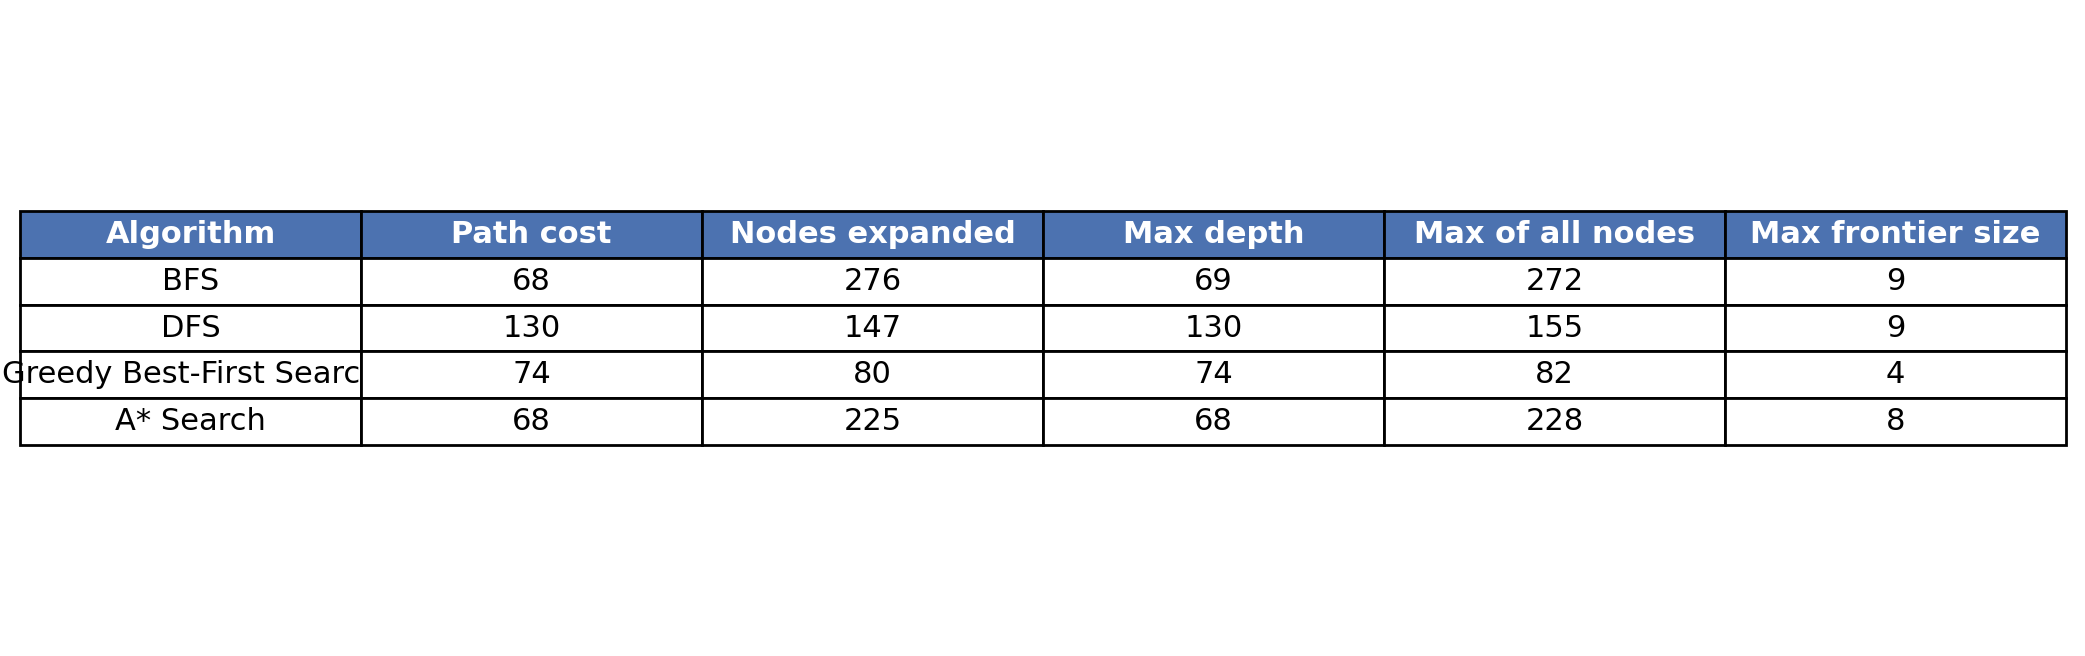

Results for maze in file: large_maze.txt


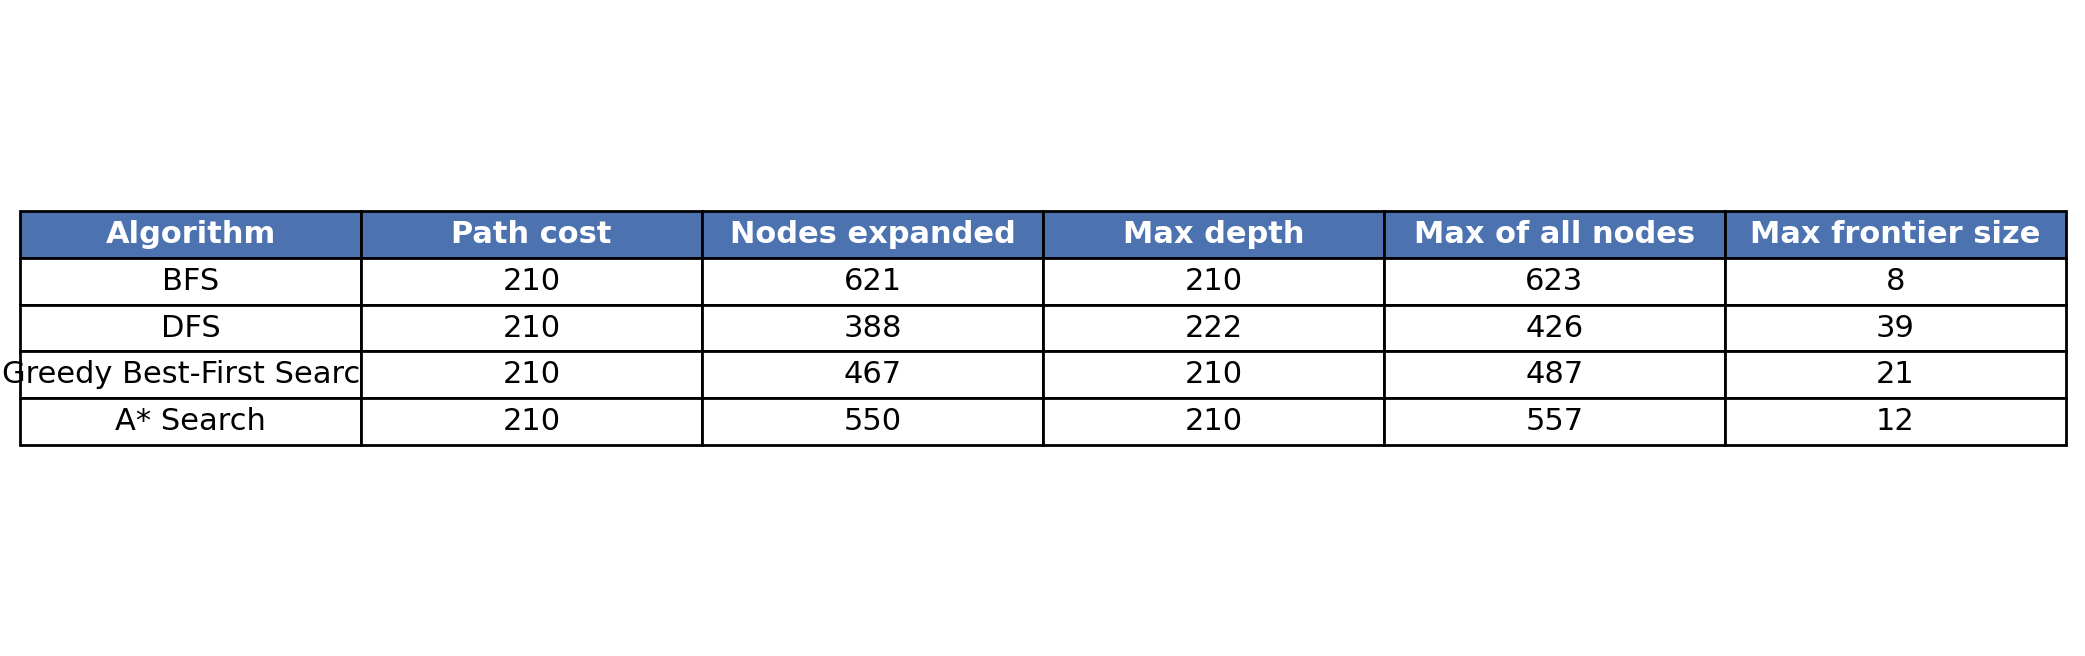

Results for maze in file: loops_maze.txt


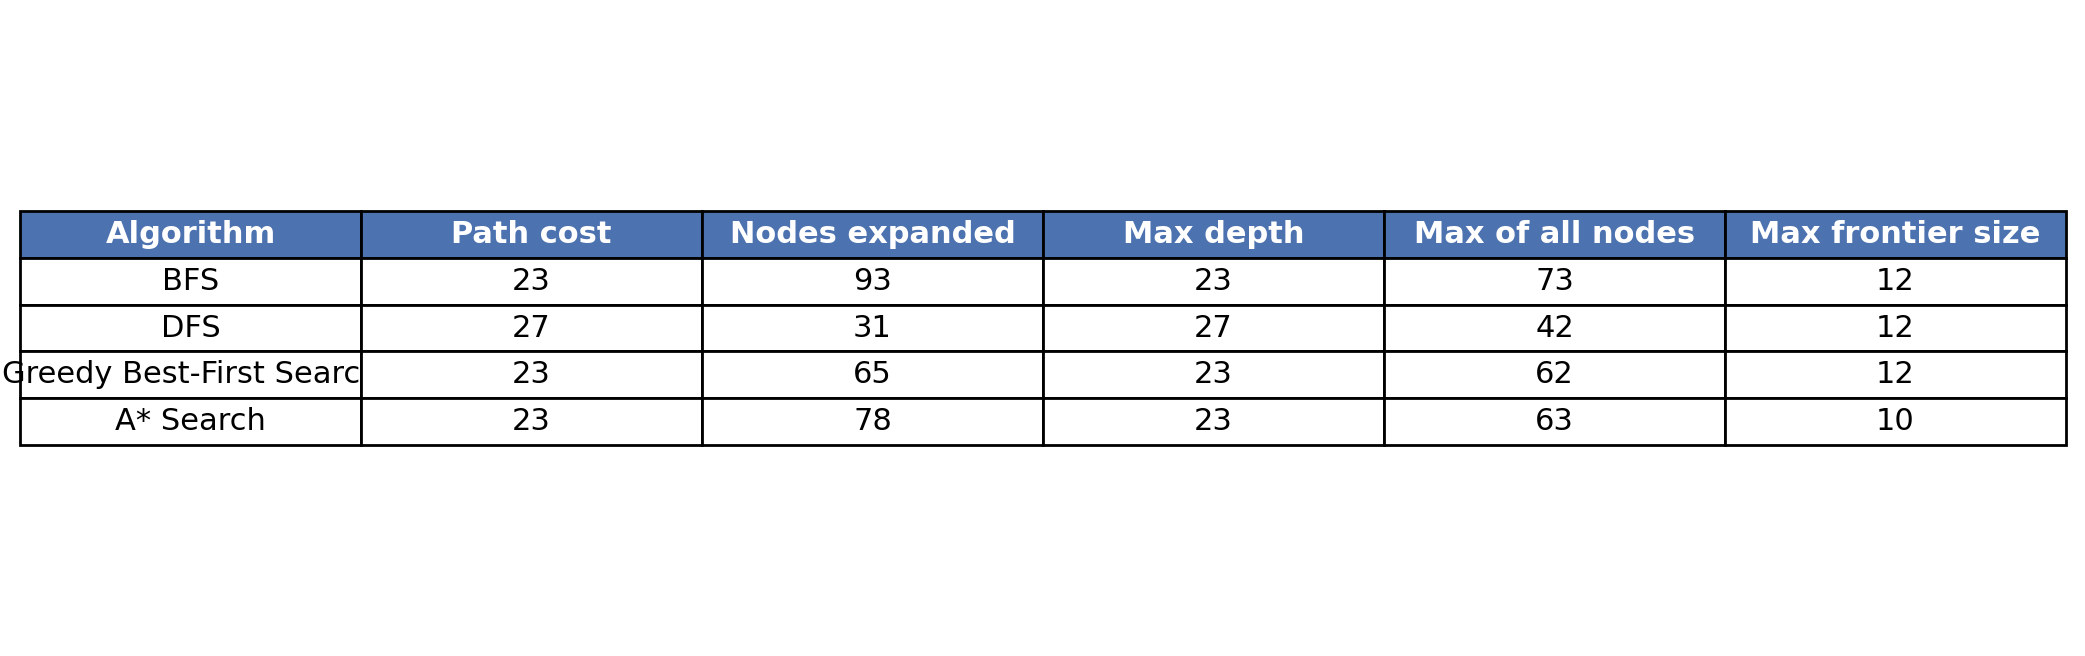

Results for maze in file: L_maze.txt


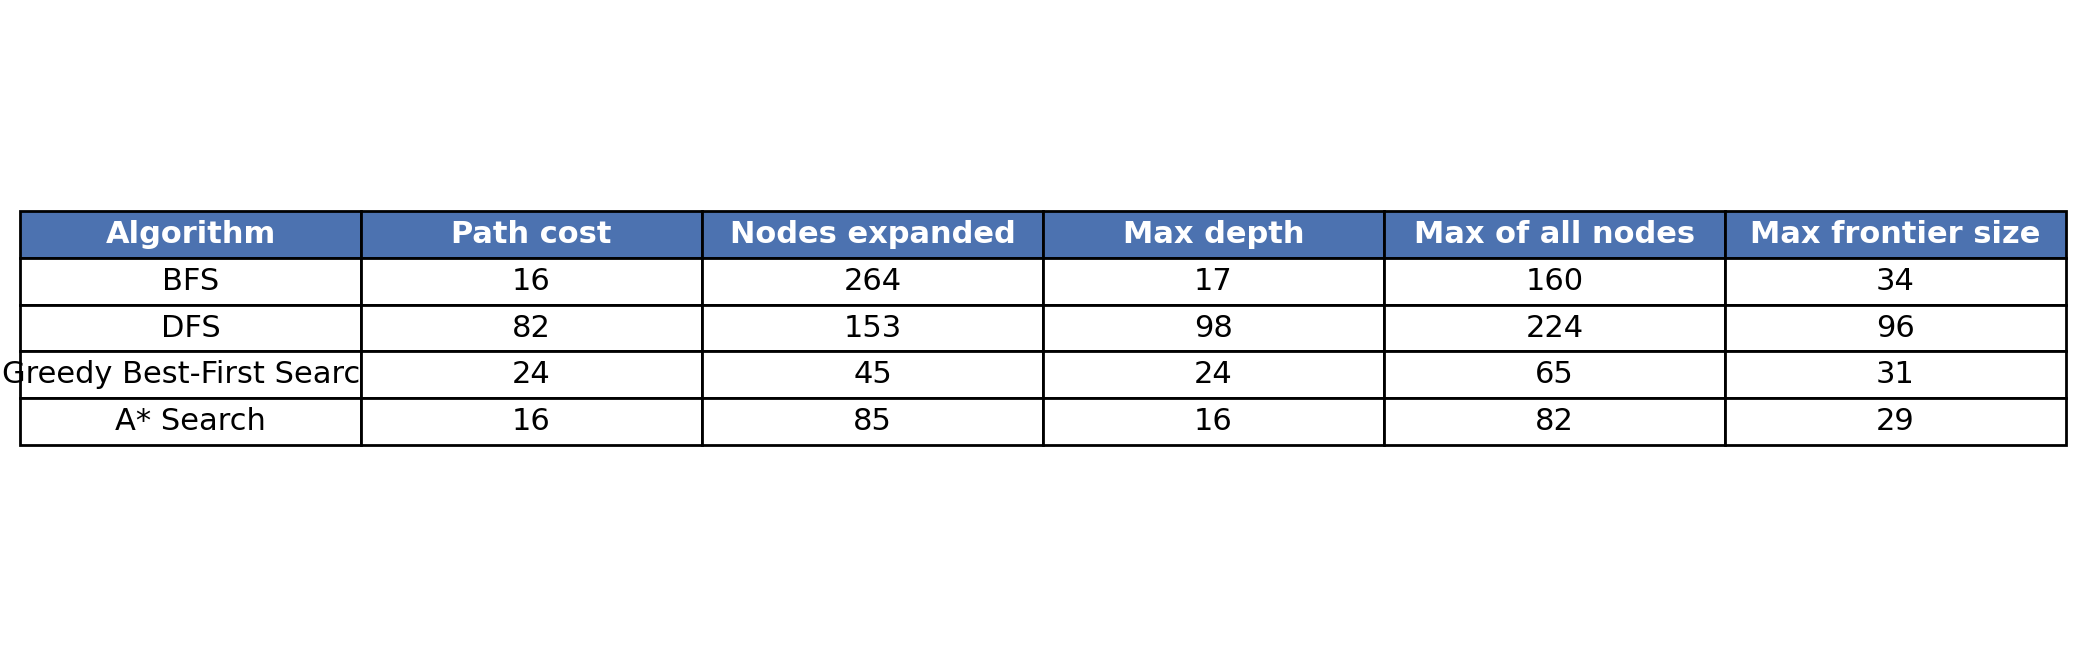

Results for maze in file: empty_maze.txt


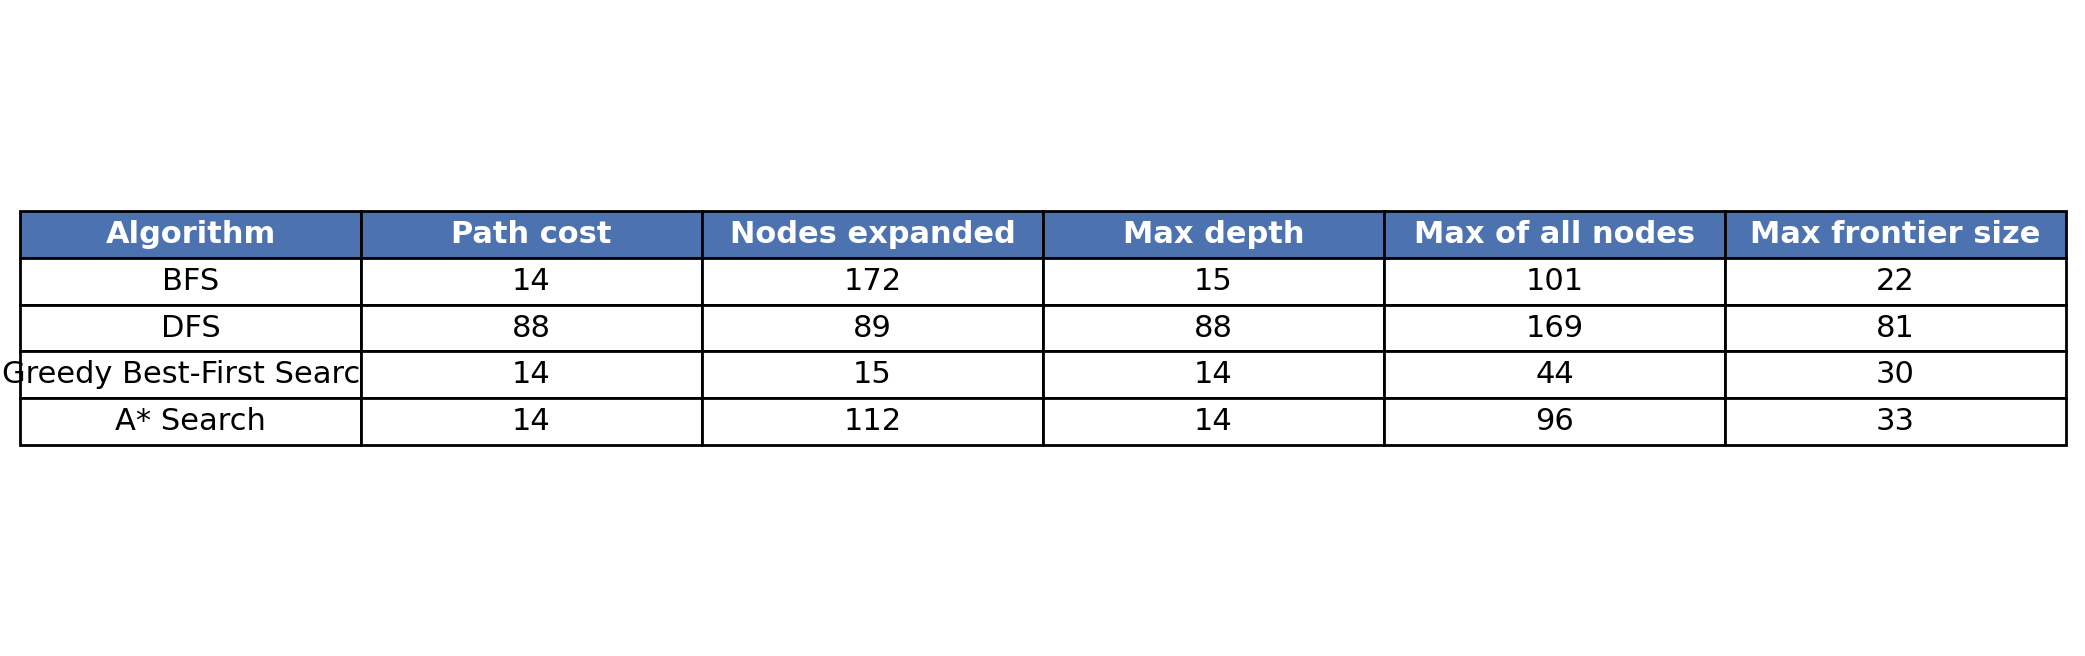

Results for maze in file: empty_maze_2.txt


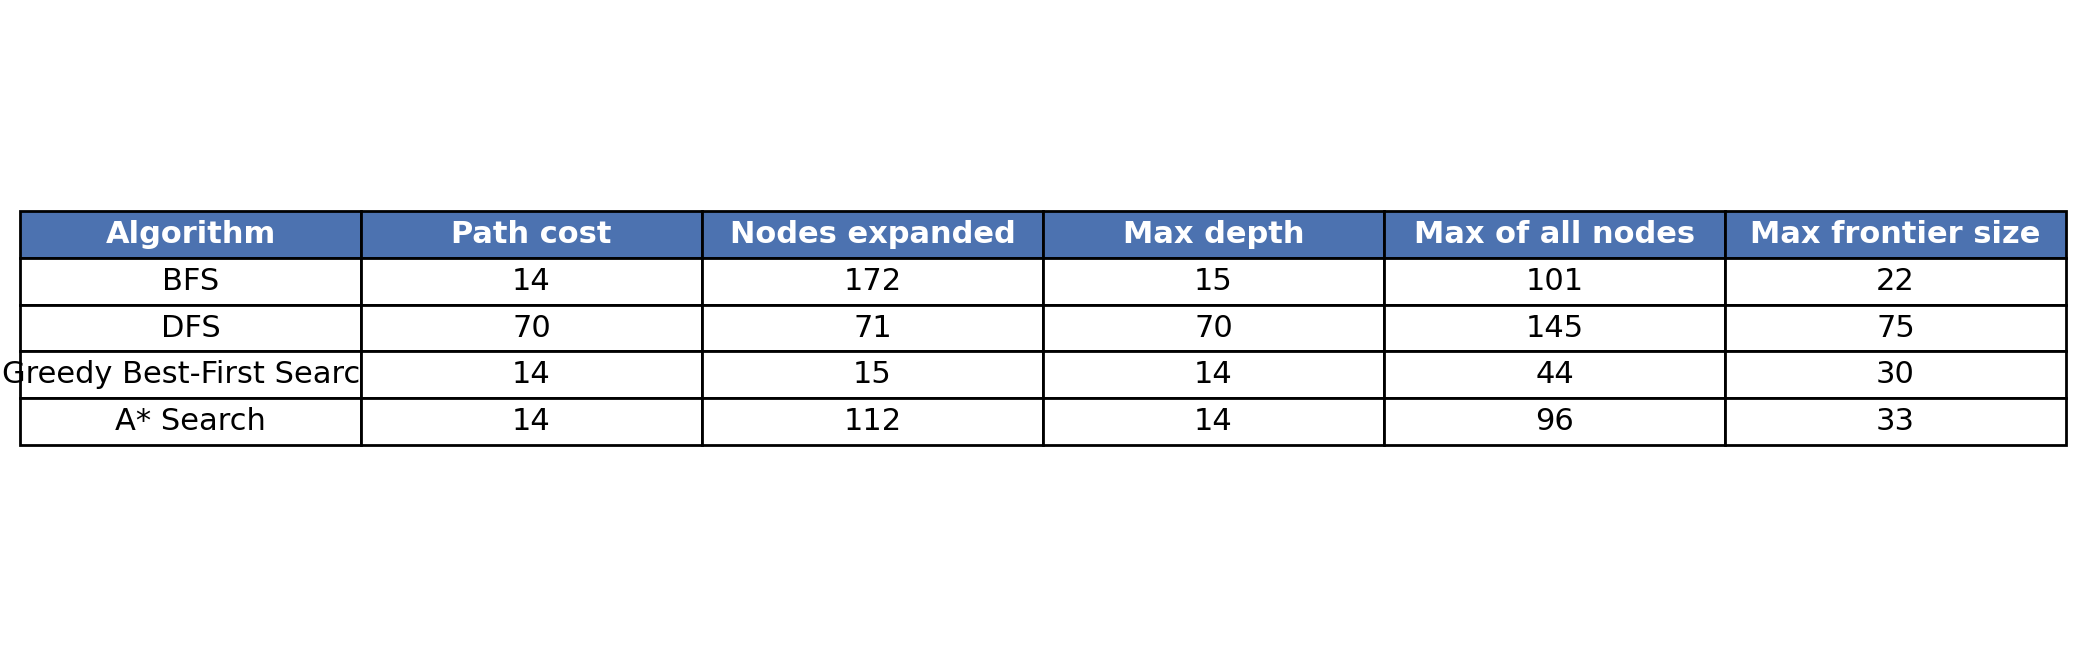

Results for maze in file: open_maze.txt


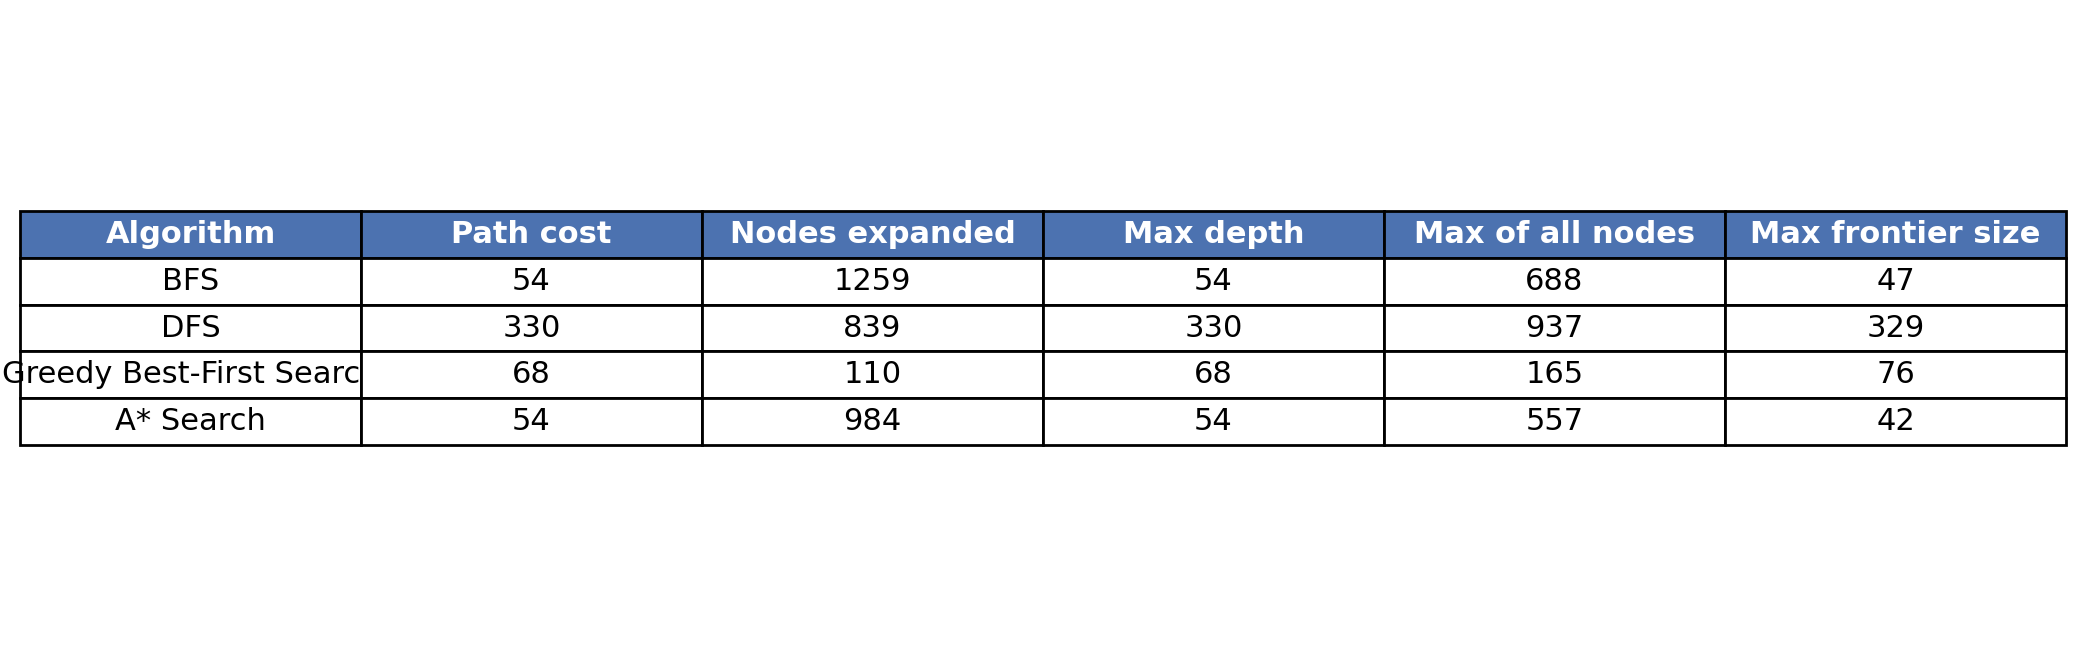

In [16]:
maze_str = ["small_maze.txt", "medium_maze.txt", "large_maze.txt","loops_maze.txt","L_maze.txt","empty_maze.txt","empty_maze_2.txt","open_maze.txt"]

maze_results_each_file = {}
for file in maze_str:
    with open(file, "r") as f:
        maze_str = f.read()
    maze = mh.parse_maze(maze_str)
    #BFS
    BFS_result = BFS_custom(maze)
    #DFS
    DFS_result = DFS_custom(maze)
    #Greedy
    Greedy_result = Greedy_best_first_search_custom(maze)
    #A*
    A_star_result = A_star_search_custom(maze)
    maze_results_each_file[file] = {
        "BFS": BFS_result,
        "DFS": DFS_result,
        "Greedy Best-First Search": Greedy_result,
        "A* Search": A_star_result
    }
    columns = ('Algorithm', 'Path cost', 'Nodes expanded', 'Max depth', 'Max of all nodes', 'Max frontier size')
    rows = ['BFS', 'DFS', 'Greedy Best-First Search', 'A* Search']

    data = [
            ['BFS', BFS_result[1], BFS_result[2], BFS_result[3], BFS_result[4], BFS_result[5]], 
            ['DFS', DFS_result[1], DFS_result[2], DFS_result[3], DFS_result[4], DFS_result[5]], 
            ['Greedy Best-First Search', Greedy_result[1], Greedy_result[2], Greedy_result[3], Greedy_result[4], Greedy_result[5]], 
            ['A* Search', A_star_result[1], A_star_result[2], A_star_result[3], A_star_result[4], A_star_result[5]] 
    ]
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.axis('off')
    table = ax.table(cellText=data,
                 colLabels=columns,
                 loc='center',
                 cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.4)
    for key, cell in table.get_celld().items():
        row, col = key
        if row == 0: 
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4C72B0')
    print(f"Results for maze in file: {file}")
    plt.show()

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [17]:
# Add discussion
# Hiểu rõ bản chất từng thuật toán:
# Mỗi thuật toán có ưu, nhược điểm riêng. BFS luôn tìm được đường đi ngắn nhất nhưng tốn nhiều bộ nhớ. DFS tiết kiệm bộ nhớ hơn nhưng dễ bị lặp vô hạn và không đảm bảo tối ưu.

# Tầm quan trọng của heuristic:
# Các thuật toán có heuristic như Greedy Best-First Search và A* cho kết quả nhanh và hiệu quả hơn nhiều nếu chọn được hàm heuristic phù hợp (ví dụ: khoảng cách Manhattan). A* thường tối ưu cả về chi phí và thời gian.

# Kiểm soát vòng lặp và trạng thái đã thăm:
# Việc kiểm tra trạng thái đã thăm (cycle checking) là rất quan trọng, đặc biệt với DFS, để tránh lặp vô hạn trong mê cung có vòng lặp.

# Quản lý bộ nhớ:
# BFS tiêu tốn nhiều bộ nhớ khi không gian trạng thái lớn, trong khi DFS và IDS tiết kiệm hơn nhưng có thể mất nhiều thời gian hơn.

# Trực quan hóa và debug:
# Việc trực quan hóa quá trình tìm kiếm giúp dễ dàng phát hiện lỗi và hiểu rõ hơn về cách thuật toán hoạt động trong thực tế.

# Không có thuật toán nào là tốt nhất cho mọi trường hợp:
# Việc lựa chọn thuật toán phù hợp phụ thuộc vào đặc điểm của bài toán (kích thước mê cung, có nhiều vòng lặp hay không, yêu cầu tối ưu hay chỉ cần tìm ra lời giải).

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS 
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

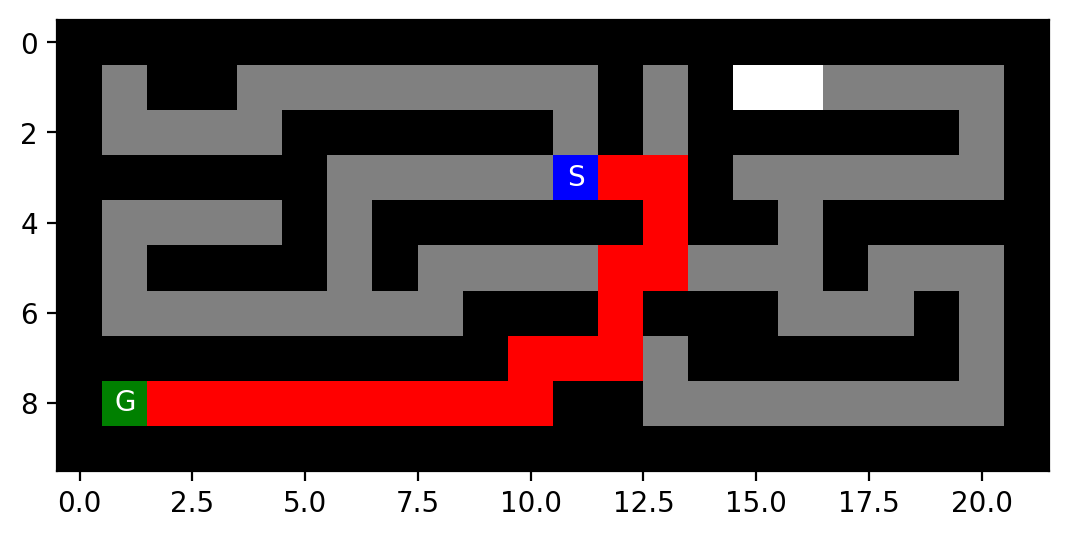

In [18]:
# Your code/answer goes here
import maze_helper as mh
import matplotlib.pyplot as plt
import  numpy as np

def DLS(node, depth, new_maze, end, action_effects):
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return True
        if depth <= 0:
            return False
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(new_maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                if DLS(new_node, depth - 1, new_maze, end, action_effects):
                    return True
        return False
def IDS(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    max_depth = 1
    while True:
        start_node = Node(start, None, None, 0)
        if DLS(start_node, max_depth, new_maze, end, action_effects):
            return new_maze
        max_depth += 1
    return -1

with open("small_maze.txt", "r") as f:
    maze_str_small = f.read()
with open("medium_maze.txt", "r") as f:
    maze_str_medium = f.read()
small_maze = mh.parse_maze(maze_str_small)
medium_maze = mh.parse_maze(maze_str_medium)

solution = IDS(small_maze)
mh.show_maze(solution)

# solution = IDS(medium_maze)
# mh.show_maze(solution)


### Result 
Thời gian chạy của mê cung nhỏ có thời gian chạy dưới 1 phút.
Nhưng với mê cung trung bình thì thuật toán không thể giải được vì thời gian quá lâu , vấn đề nằm ở việc chọn chiều sau cho mỗi lần chạy , mỗi lần chạy với độ sâu mới thì ta vẫn phải chạy lại toàn bộ những độ sâu trước đó , độ phức tạp là b^d với d là độ sâu , và b là số trạng thái con được sinh ra 

### Multiple Goals 
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [19]:

#BFS_multi goals
def BFS_multi(maze, positions):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    end = positions
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop(0)
        if node.pos in end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze

#DFS multi goals
def DFS_multi(maze, positions):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what="S")
    ends = positions
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None, action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        node = frontier.pop()
        if node.pos in ends:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X" and new_pos not in reached:
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze
#IDS multi goals
def new_IDS(maze, position):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  position
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    max_depth = 1
    while True:
        start_node = Node(start, None, None, 0)
        if DLS(start_node, max_depth, new_maze, end, action_effects):
            return new_maze
        max_depth += 1
    return new_maze 
def DLS(node, depth, new_maze, end, action_effects):
        if node.pos in end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return True
        if depth <= 0:
            return False
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(new_maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."
                new_node = Node(new_pos, node, action, node.cost + 1)
                if DLS(new_node, depth - 1, new_maze, end, action_effects):
                    return True
        return False
    
    
    
    

Path form start to goal using DFS:


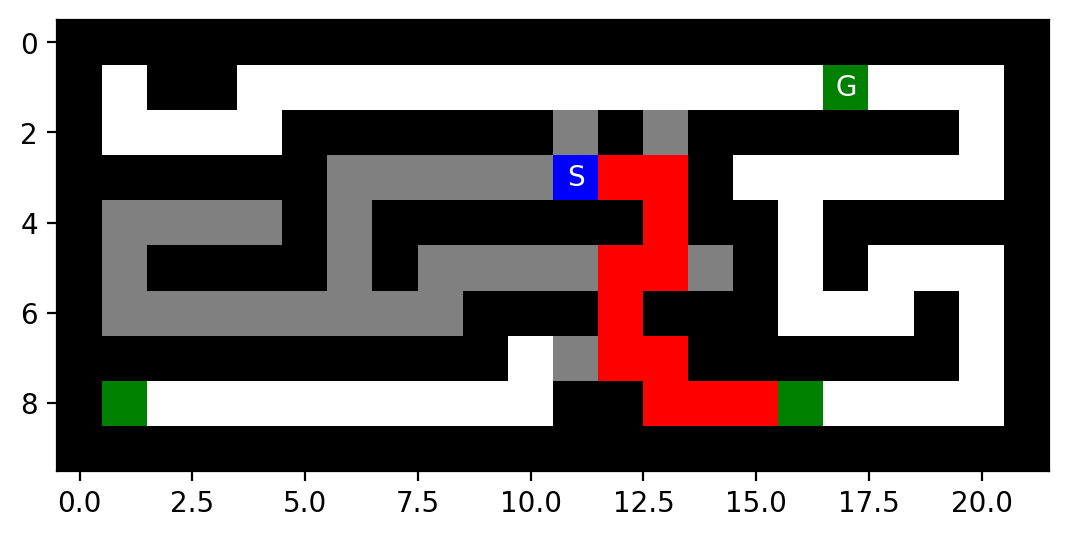

Path form start to goal using BFS:


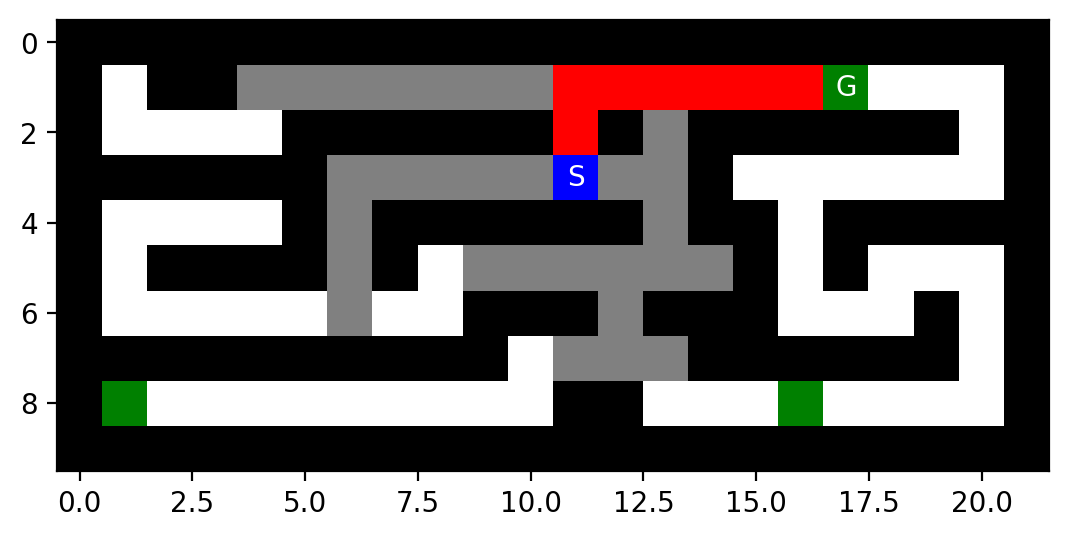

Path form start to goal using IDS:


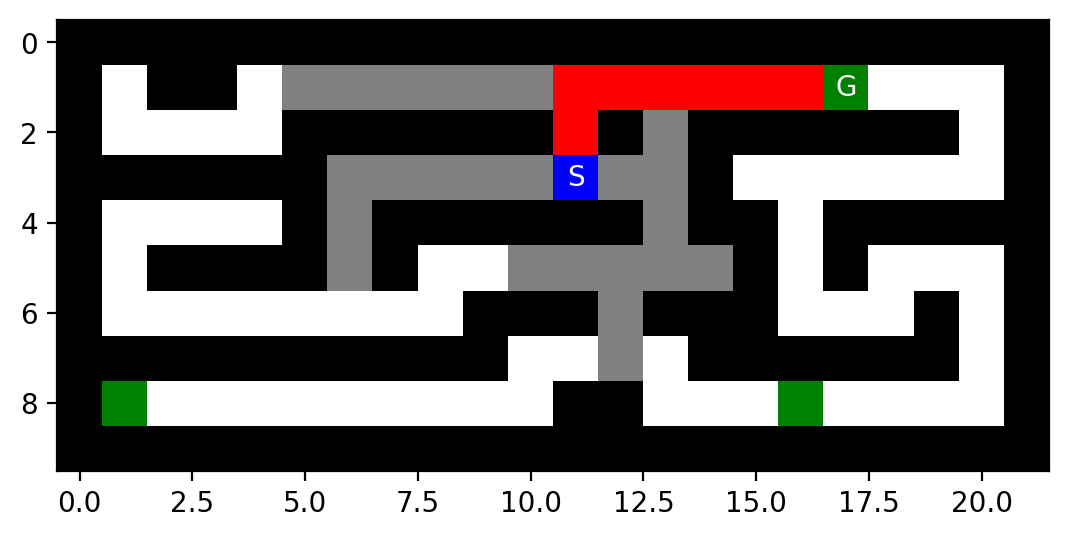

In [20]:
# Your code/answer goes here
with open("new_maze.txt", "r") as f:
    new_maze = f.read()

new_maze = mh.parse_maze(new_maze)
def find_pos_multiple_goals(maze, what="G"):
    positions = []
    for r in range(maze.shape[0]):
        for c in range(maze.shape[1]):
            if maze[r, c] == what:
                positions.append((r, c))
    return positions
end_positions = find_pos_multiple_goals(new_maze, what="G")
bdsout =DFS_multi(new_maze, end_positions)
#DFS
print(f"Path form start to goal using DFS:")
mh.show_maze(bdsout)

bdsout =BFS_multi(new_maze, end_positions)
#BFS
print(f"Path form start to goal using BFS:")
mh.show_maze(bdsout)

bdsout = new_IDS(new_maze, end_positions)
#IDS
print(f"Path form start to goal using IDS:")
mh.show_maze(bdsout)





## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [21]:
# Your code/answer goes here


### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

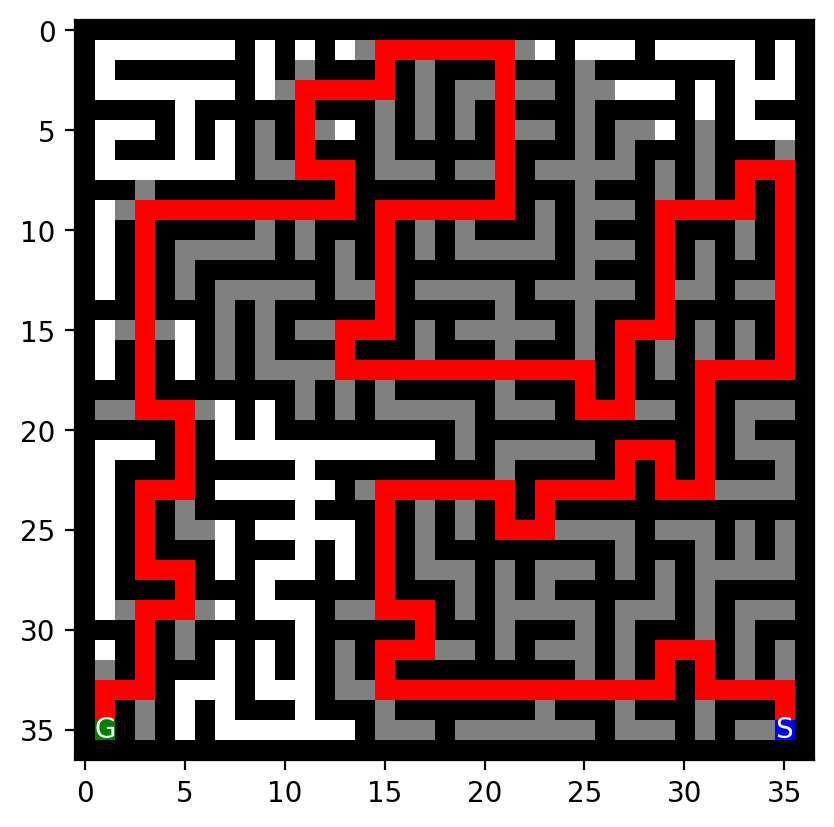

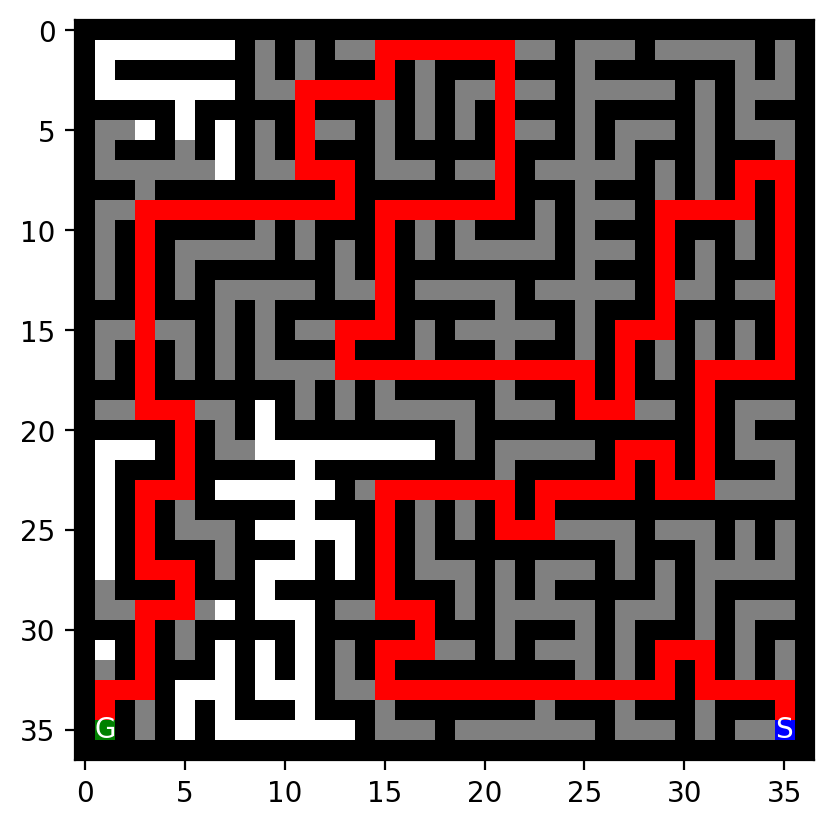

In [ ]:
# Your code/answer goes here
def A_star_search_add_weight(maze):
    new_maze = maze.copy().astype(str)
    start = mh.find_pos(maze, what = "S")
    end =  mh.find_pos(maze, what = "G")
    reached = set()
    frontier = []
    action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    start_node = Node(start, None,action_effects, 0)
    frontier.append(start_node)
    while len(frontier) > 0:
        # Weight = 10
        # Sort the frontier based on the f(n) = g(n) + 10*h(n)
        frontier.sort(key=lambda node: node.cost + 10*(abs(node.pos[0] - end[0]) + abs(node.pos[1] - end[1])))
        node = frontier.pop(0)  # Pop the node with the lowest f(n) value
        if node.pos == end:
            path = node.get_path_from_root()
            for n in path:
                if new_maze[n.pos] not in ["S", "G"]:
                    new_maze[n.pos] = "P"
            return new_maze
        if node.pos in reached:
            continue
        reached.add(node.pos)
        for action in action_effects:
            new_pos = (node.pos[0] + action[0], node.pos[1] + action[1])
            if mh.look(maze, new_pos) != "X":
                if new_maze[new_pos] not in ["S", "G"]:
                    new_maze[new_pos] = "."  # đánh dấu đã explore
                new_node = Node(new_pos, node, action, node.cost + 1)
                frontier.append(new_node)
    return new_maze
with open("large_maze.txt", "r") as f:
    maze_str_medium = f.read()
    
medium_maze = mh.parse_maze(maze_str_medium)
new = A_star_search_add_weight(medium_maze)
mh.show_maze(new)
new = A_star_search(medium_maze)
mh.show_maze(new)


### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [23]:
# # Your code/answer goes here
# Nếu tác nhân không biết trước bản đồ mê cung, môi trường trở thành không xác định và không quan sát đầy đủ. Khi đó:

# 1. Mô tả môi trường theo PEAS:
# Performance measure (P):
# Đến được mục tiêu càng nhanh càng tốt, số bước di chuyển ít nhất, tránh va vào tường.
# Environment (E):
# Mê cung không biết trước, chỉ biết trạng thái hiện tại và các ô lân cận (có thể chỉ biết khi di chuyển đến).
# Actuators (A):
# Di chuyển lên/xuống/trái/phải.
# Sensors (S):
# Cảm biến phát hiện tường, vị trí hiện tại, có thể biết khoảng cách đến mục tiêu nếu có GPS.
# 2. Cách xây dựng tác nhân hợp lý:
# Khám phá và xây dựng bản đồ:
# Tác nhân cần vừa di chuyển vừa khám phá, ghi nhớ các ô đã đi qua và các bức tường phát hiện được.
# Chiến lược tìm kiếm:
# Có thể dùng thuật toán như DFS/BFS/A* trên bản đồ tạm thời đã khám phá.
# Nếu gặp ngõ cụt, quay lại và thử hướng khác (giống giải mê cung thực tế).
# Nếu có GPS, dùng khoảng cách đến mục tiêu làm heuristic cho A* để ưu tiên hướng đi gần mục tiêu.
# Cập nhật tri thức:
# Sau mỗi bước, cập nhật bản đồ nội bộ và điều chỉnh kế hoạch nếu phát hiện đường đi bị chặn.
# 3. Nếu có GPS:
# Lợi ích:
# GPS cung cấp khoảng cách đến mục tiêu, giúp tác nhân định hướng tốt hơn (ưu tiên các hướng giảm khoảng cách).
# Áp dụng:
# Kết hợp khám phá với A* heuristic dựa trên GPS để tìm đường hiệu quả hơn, dù chưa biết toàn bộ mê cung.
# Tóm lại:
# Tác nhân cần vừa khám phá vừa lập kế hoạch, sử dụng thông tin cảm biến để cập nhật bản đồ và điều chỉnh chiến lược tìm kiếm. Nếu có GPS, tác nhân sẽ tìm đường nhanh và hiệu quả hơn nhờ biết hướng ưu tiên đến mục tiêu.